# Klasifikasi Tangan Membentuk Gunting, Kertas, dan Batu

Program untuk mengenali bentuk jari tangan yang membentuk gunting, kertas, atau batu.
<br>
Program ini dibuat menggunakan CNN dengan library Keras dan backend TensorFlow.


## Import Library

In [28]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from skimage.io import imread
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# Mengihitung waktu lamanya eksekusi tiap sel di Google Colab
!pip install ipython-autotime

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.51 s


### Checking Tensorflow Version

In [2]:
print(tf.__version__)

2.2.0


## Preprocessing Datasets

Mengunduh dataset rockpaperscissors dan menyimpannya di penyimpanan sementara pada Google Colab di dalam direktori "content".
(Dataset yang digunakan berlatar belakang warna hijau).

In [3]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /content/rockpaperscissors.zip

--2020-07-08 12:50:49--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/content/rockpaperscissors.zip’

/content/rockpapers 100%[===================>] 307.92M  23.7MB/s    in 15s     

2020-07-08 12:51:04 (21.2 MB/s) - ‘/content/rockpaperscissors.zip’ saved [322873683/322873683]



Extracting datasets into "datasets" directory.

In [4]:
# melakukan ekstraksi pada file zip
import zipfile,os
local_zip = "rockpaperscissors.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/content/datasets")
zip_ref.close()

### Visualizing one of picture for each class

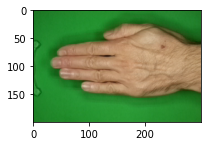

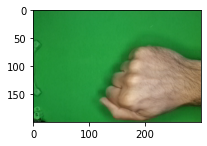

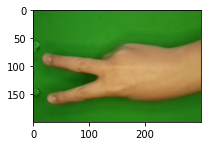

In [5]:
# Perintah untuk memvisualisasikan satu gambar dari dataset
# kertas
image = imread("datasets/rockpaperscissors/rps-cv-images/paper/0a3UtNzl5Ll3sq8K.png")
plt.figure(figsize=(3,3))
plt.imshow(image)
# batu
image = imread("datasets/rockpaperscissors/rps-cv-images/rock/00nKV8oHuTGi20gq.png")
plt.figure(figsize=(3,3))
plt.imshow(image)
# gunting
image = imread("datasets/rockpaperscissors/rps-cv-images/scissors/0CSaM2vL2cWX6Cay.png")
plt.figure(figsize=(3,3))
plt.imshow(image)

### Creating Object ImageDataGenerator & Data Augmentation

Membuat obyek gambar *dataset* dengan **ImageDataGenerator**, Autmentasi *dataset*, dan Membagi *dataset* validasi (*validation*) sebesar 20% dan *dataset* pelatihan (*training*) sebesar 80%.

In [7]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split = 0.2,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2,    
    vertical_flip = True,
    fill_mode = "nearest")

### Using ImageDataGenerator Object

Menggunakan obyek **ImageDataGenerator** yang sudah dibuat

In [19]:
#Memuat dataset pelatihan & validasi
base_dir = os.path.join("datasets/rockpaperscissors/rps-cv-images")

img_size = 150
batch_size = 64

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size, 
    subset='training',
    class_mode= 'categorical')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size, 
    subset='validation',
    class_mode= 'categorical')

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.
Bentuk array dari dataset train (pelatihan) adalah: (64, 150, 150, 3) (64, 3)
Bentuk array dari dataset validation (validasi) adalah: (64, 150, 150, 3) (64, 3)
time: 1.1 s


## Developing CNN Architecture (Creating Model)

Membuat arsitektur CNN mulai dari  Lapisan Masukkan (*Input Layer*), Lapisan Konvolusi (*Convolution Layer*), Lapisan aktivasi (*Activation Layer*), *Pooling Layer*, dan Lapisan terhubung erat (*Fully Connected Layer/Densely Connected Layer*).

In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(150, 150, 3)), padding="same",
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation="softmax")
])

time: 130 ms


### Compiling Model

In [21]:
model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 15, 15, 128)      

### Pelatihan Model

Melatih model dari arsitektur CNN yang telah dibuat. Pada program ini dibuat sebanyak 100 epoch, namun jika *error/loss* sudah sangat kecil sebelum *epoch* ke 100 maka akan berhenti di *epoch* tersebut.

In [29]:
es = EarlyStopping(monitor = "val_loss", patience = 10, verbose = 1, mode = "auto")
history = model.fit(train_generator, 
                    epochs = 100, 
                    callbacks = [es],
                    validation_data = val_generator)

Epoch 1/100
28/28 [==============================] - 17s 604ms/step - loss: 0.5513 - acc: 0.7904 - val_loss: 0.4427 - val_acc: 0.8146
Epoch 2/100
28/28 [==============================] - 17s 607ms/step - loss: 0.4643 - acc: 0.8132 - val_loss: 0.4513 - val_acc: 0.8124
Epoch 3/100
28/28 [==============================] - 17s 604ms/step - loss: 0.3889 - acc: 0.8458 - val_loss: 0.3907 - val_acc: 0.8627
Epoch 4/100
28/28 [==============================] - 17s 601ms/step - loss: 0.3982 - acc: 0.8481 - val_loss: 0.3881 - val_acc: 0.8650
Epoch 5/100
28/28 [==============================] - 18s 626ms/step - loss: 0.3743 - acc: 0.8509 - val_loss: 0.3489 - val_acc: 0.8787
Epoch 6/100
28/28 [==============================] - 17s 604ms/step - loss: 0.3788 - acc: 0.8469 - val_loss: 0.4407 - val_acc: 0.8055
Epoch 7/100
28/28 [==============================] - 17s 613ms/step - loss: 0.3571 - acc: 0.8664 - val_loss: 0.2625 - val_acc: 0.9108
Epoch 8/100
28/28 [==============================] - 17s 602ms

### Visualizing Training Model Result

Menampilkan grafik model hasil pelathiannya pada setiap *epoch*.

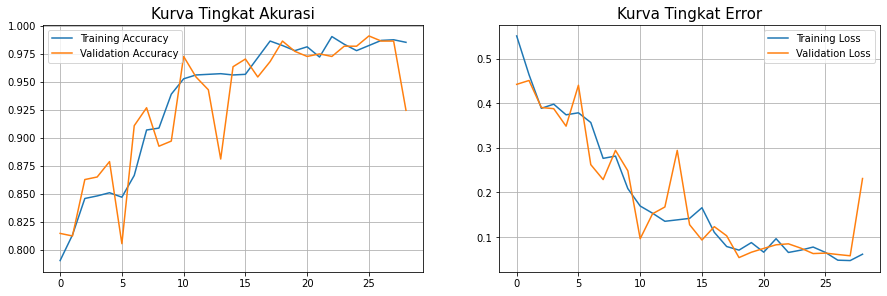

time: 398 ms


In [38]:
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)

plt.subplot(2, 2, 1)
plt.plot(history.history["acc"],label = "Training Accuracy")
plt.plot(history.history["val_acc"],label = "Validation Accuracy")
plt.legend()
plt.title("Kurva Tingkat Akurasi", size=15)
plt.grid(zorder = 0)

plt.subplot(2, 2, 2)
plt.plot(history.history["loss"],label = "Training Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.title("Kurva Tingkat Error", size=15)
plt.grid(zorder = 0)
plt.show()

## Prediction from Image Files

Menguji hasil prediksi gambar yang diupload terhadap model hasil pelatihannya.

Saving Transparent Background.png to Transparent Background.png
Transparent Background.png
Bentuk array hasil prediksi [[0. 1. 0.]]
Prediksi: rock


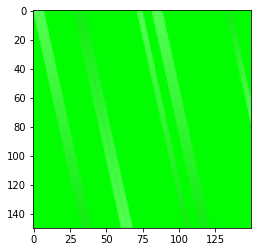

time: 57.2 s


In [35]:
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  print("Bentuk array hasil prediksi:", classes)
  if classes[0][0]==1:
    print("Prediksi: paper")
  elif classes[0][1]==1:
    print("Prediksi: rock")
  else:
    print("Prediksi: scissors")